In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML1M'

In [2]:
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import sklearn as sklearn
import datetime as dt 
import seaborn as sns
import torch as torch
from sklearn import metrics
import pickle

In [4]:
ratings=pd.read_csv(f'{DATAPATH}/ratings.dat',engine='python',sep='::',names=['userId','itemId','rating','timestamp'])
print (ratings.head())

   userId  itemId  rating  timestamp
0       1    1193       5  978300760
1       1     661       3  978302109
2       1     914       3  978301968
3       1    3408       4  978300275
4       1    2355       5  978824291


In [5]:
ratings.shape, ratings['userId'].nunique(),ratings['itemId'].nunique()

((1000209, 4), 6040, 3706)

In [6]:
users=pd.read_csv(f'{DATAPATH}/users.dat',engine='python',sep='::',names=['userId','gender','age','occupation','zip'])
print (users.head())

   userId gender  age  occupation    zip
0       1      F    1          10  48067
1       2      M   56          16  70072
2       3      M   25          15  55117
3       4      M   45           7  02460
4       5      M   25          20  55455


In [7]:
items=pd.read_csv(f'{DATAPATH}/movies.dat',engine='python',sep='::',names=['itemId','title','genre'])
print (items.head())

   itemId                               title                         genre
0       1                    Toy Story (1995)   Animation|Children's|Comedy
1       2                      Jumanji (1995)  Adventure|Children's|Fantasy
2       3             Grumpier Old Men (1995)                Comedy|Romance
3       4            Waiting to Exhale (1995)                  Comedy|Drama
4       5  Father of the Bride Part II (1995)                        Comedy


In [8]:
ratings=pd.merge(ratings,users,on='userId',how='left')

In [9]:
ratings.shape

(1000209, 8)

In [10]:
ratings=pd.merge(ratings,items,on='itemId',how='left')

In [11]:
ratings.shape

(1000209, 10)

In [12]:
ratings.head().T

,0,1,2,3,4
userId,1,1,1,1,1
itemId,1193,661,914,3408,2355
rating,5,3,3,4,5
timestamp,978300760,978302109,978301968,978300275,978824291
gender,F,F,F,F,F
age,1,1,1,1,1
occupation,10,10,10,10,10
zip,48067,48067,48067,48067,48067
title,One Flew Over the Cuckoo's Nest (1975),James and the Giant Peach (1996),My Fair Lady (1964),Erin Brockovich (2000),"Bug's Life, A (1998)"
genre,Drama,Animation|Children's|Musical,Musical|Romance,Drama,Animation|Children's|Comedy


In [13]:
dfratings=ratings.copy()

In [14]:
dfratings['timestamp']=pd.to_datetime(dfratings['timestamp'],unit='s')

### Charts 

In [15]:
dfratings.head()

,userId,itemId,rating,timestamp,gender,age,occupation,zip,title,genre
0,1,1193,5,2000-12-31 22:12:40,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,2000-12-31 22:35:09,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,2000-12-31 22:32:48,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,2000-12-31 22:04:35,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,2001-01-06 23:38:11,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [18]:
dfratings['year']=dfratings['timestamp'].dt.year

In [19]:
# How are the ratings distributed by year
ratings_by_year=dfratings['year'].value_counts().sort_index()
ratings_by_year=pd.DataFrame(ratings_by_year)
ratings_by_year.reset_index(inplace=True)
ratings_by_year.columns=['Year','numratings']
ratings_by_year['Year']=ratings_by_year['Year'].astype(str)

Text(0.5, 1.0, 'Ratings by Year')

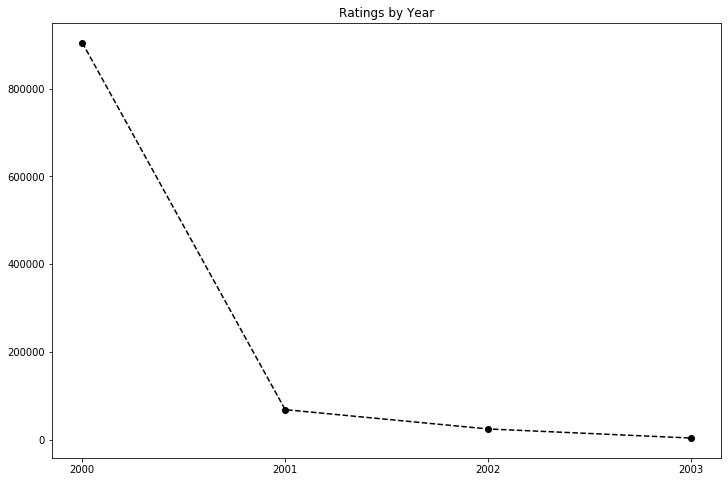

In [20]:
figure=plt.figure(figsize=(12,8))
plt.plot (ratings_by_year['Year'],ratings_by_year['numratings'],'o--', color='black')
plt.title('Ratings by Year')

In [23]:
dfratings.sort_values(by=['userId','timestamp'],inplace=True)

In [24]:
dfratings['seqNum']=dfratings.groupby('userId').cumcount()+1

In [25]:
temp=dfratings.loc[dfratings['seqNum']==1].year.value_counts().sort_index()

In [26]:
temp=pd.DataFrame(temp)

In [27]:
temp.reset_index(inplace=True)
temp.columns=['year','new_Users']

Text(0, 0.5, 'New Users')

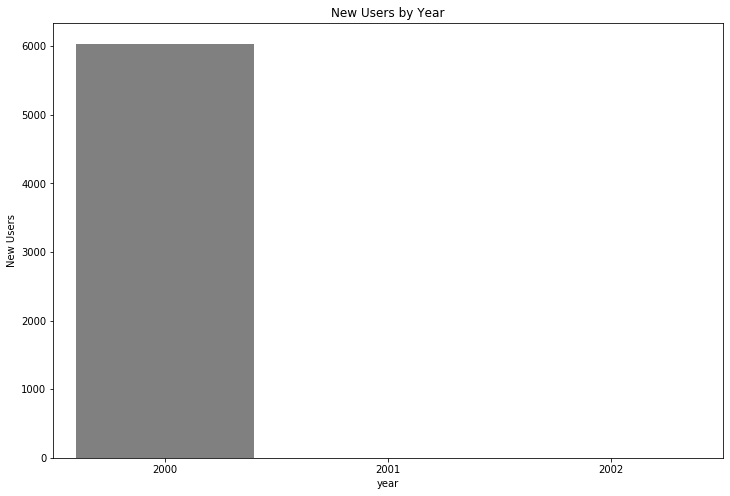

In [28]:
figure=plt.figure(figsize=(12,8))
ax=sns.barplot(x=temp['year'],y=temp['new_Users'],color='grey')
ax.set_title('New Users by Year')
ax.set_ylabel ('New Users')

### CROSS-VALIDATION - SIMULATE COLD START

In [25]:
# normal method is to keep the first x% of the ratings for each user as training and the rest as validation
# we want to simulate cold start by applying above only to users who were acquired in older years except last 2 years

In [26]:
dfratings.sort_values(by=['userId','timestamp'],inplace=True)

In [27]:
dfratings['seqNum']=dfratings.groupby('userId').cumcount()+1

In [28]:
dfratings['year']=dfratings['timestamp'].dt.year

In [29]:
dfratings['month']=dfratings['timestamp'].dt.month

In [30]:
dfacqyear=dfratings.loc[dfratings['seqNum']==1,['userId','year','month']]

In [31]:
dfratings=pd.merge(dfratings,dfacqyear,on='userId',how="left",suffixes=("","_acq"))

In [34]:
dfratings[['year_acq','month_acq']].head()

,year_acq,month_acq
0,2000,12
1,2000,12
2,2000,12
3,2000,12
4,2000,12


In [45]:
dfratings['year_month_acq']=dfratings['year_acq'].astype(str)+\
    np.where(dfratings['month_acq']>9,dfratings['month_acq'].astype(str),"0"+dfratings['month_acq'].astype(str))

In [48]:
dfratings['year_month_acq'].value_counts()

200011    350437
200008    200206
200007    101970
200012    100343
200005     78304
200006     61238
200009     50431
200010     41291
200004     14927
200106       343
200111       268
200203       143
200102       136
200211       136
200105        36
Name: year_month_acq, dtype: int64

In [49]:
dfratings['year_month_acq']=dfratings['year_month_acq'].astype(int)

In [50]:
dfratings['year_month_acq'].value_counts().sort_index()

200004     14927
200005     78304
200006     61238
200007    101970
200008    200206
200009     50431
200010     41291
200011    350437
200012    100343
200102       136
200105        36
200106       343
200111       268
200203       143
200211       136
Name: year_month_acq, dtype: int64

In [51]:
dfsimulate=dfratings.loc[dfratings['year_month_acq']>200011]
dfnormal=dfratings.loc[dfratings['year_month_acq']<=200011]

In [52]:
postusers=dfsimulate['userId'].unique()

In [53]:
postusers=np.random.permutation(postusers)

In [54]:
trainfrac=0.9

In [55]:
postusers_train=postusers[:np.int(np.round(len(postusers)*trainfrac))]

In [56]:
dfsimulate['flag_train']=dfsimulate['userId'].isin(postusers_train)

/home/kirana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
dfsimulate['flag_train'].value_counts()

True     92163
False     9242
Name: flag_train, dtype: int64

In [58]:
dfseq=dfnormal.groupby('userId',as_index=False)['seqNum'].max()

In [59]:
dfseq.head()

,userId,seqNum
0,670,90
1,671,135
2,672,47
3,673,403
4,674,79


In [60]:
dfseq.columns=['userId','maxSeqNum']

In [61]:
dfnormal=pd.merge(dfnormal,dfseq,on='userId',how='left')

In [62]:
dfnormal['flag_train']=np.where(dfnormal['seqNum']<np.round(trainfrac*dfnormal['maxSeqNum']).astype(np.int),1,0)

In [63]:
dfnormal['flag_train'].value_counts()

1    803575
0     95229
Name: flag_train, dtype: int64

In [64]:
trainfrac

0.9

In [65]:
dftrain=pd.concat([dfnormal.loc[dfnormal['flag_train']==1],dfsimulate.loc[dfsimulate['flag_train']==1]],axis=0,sort=True)

In [66]:
dfvalid=pd.concat([dfnormal.loc[dfnormal['flag_train']!=1],dfsimulate.loc[dfsimulate['flag_train']!=1]],axis=0,sort=True)

In [67]:
dftrain.shape, dfvalid.shape

((895738, 18), (104471, 18))

In [68]:
dftrain.dtypes

age                        int64
flag_train                 int64
gender                    object
genre                     object
itemId                     int64
maxSeqNum                float64
month                      int64
month_acq                  int64
occupation                 int64
rating                     int64
seqNum                     int64
timestamp         datetime64[ns]
title                     object
userId                     int64
year                       int64
year_acq                   int64
year_month_acq             int64
zip                       object
dtype: object

In [69]:
import pickle

In [70]:
dfvalid['flag_train'].value_counts()

0    104471
Name: flag_train, dtype: int64

In [71]:
pickle.dump([dftrain,dfvalid],open(f'{DATAPATH}/df.pkl','wb'))